#1、数据集加载

参考：https://github.com/Meiyun-Tan/kkbAssignment/blob/master/BI04%E5%90%8D%E4%BC%81%E7%8F%AD/MQ_BI04_lesson03_Action01_delicious_recommend.ipynb

In [54]:
import pandas as pd

In [55]:
df_user_contacts=pd.read_table("/content/drive/MyDrive/推荐系统/delicious_用户标签/hetrec2011-delicious-2k/user_contacts.dat",sep="\t",encoding="utf-8")
print(df_user_contacts.shape)
df_user_contacts.head(5)

(15328, 8)


,userID,contactID,date_day,date_month,date_year,date_hour,date_minute,date_second
0,8,28371,4,10,2010,2,14,19
1,8,40306,3,10,2010,12,33,9
2,8,85279,2,10,2010,3,10,48
3,8,91764,4,10,2010,22,43,47
4,8,97723,12,10,2010,3,28,33


In [56]:
df_user_contacts_ts=pd.read_table("/content/drive/MyDrive/推荐系统/delicious_用户标签/hetrec2011-delicious-2k/user_contacts-timestamps.dat",sep="\t",encoding="utf-8")
print(df_user_contacts_ts.shape)
df_user_contacts_ts.head(5)

(15328, 3)


,userID,contactID,timestamp
0,8,28371,1286151259000
1,8,40306,1286101989000
2,8,85279,1285981848000
3,8,91764,1286225027000
4,8,97723,1286846913000


##1.1 认识数据集
用户user对bookmark书签进行打标签tag的数据集。

网站的tag可以理解为分类；

用户的tag可以理解为兴趣；

In [57]:
df = pd.read_csv('/content/drive/MyDrive/推荐系统/delicious_用户标签/hetrec2011-delicious-2k/user_taggedbookmarks-timestamps.dat', sep='\t')
df.head(5)
df["tagID"]

0            1
1            1
2            1
3            6
4            7
          ... 
437588     193
437589     673
437590     130
437591     267
437592    4943
Name: tagID, Length: 437593, dtype: int64

In [58]:
df.shape  #一共437593个数据，具有4个特征

(437593, 4)

In [59]:
#查看空值,any方法按列统计
df.isnull().any()

userID        False
bookmarkID    False
tagID         False
timestamp     False
dtype: bool

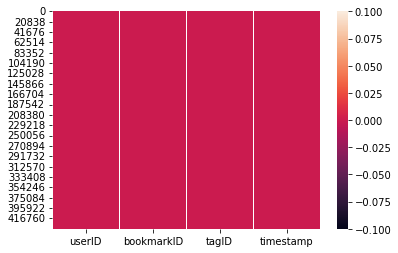

In [60]:
#查看空值得可视化方法
import seaborn as sns
sns.heatmap(df.isnull())

In [61]:
# 一共有1867个用户
df['userID'].unique().shape

(1867,)

In [62]:
# 去重后一共有40897个标签
df['tagID'].unique().shape

(40897,)

In [64]:
# 去重后一共有69223个书签
df['bookmarkID'].unique().shape

(69223,)

In [65]:
df.duplicated().sum() #无重复行，用sum和count都行

0

##构建{userID：{bookmarkID：[tagIDs]}}映射关系

In [66]:
#字典类型，保存user对item的tag，即{userid:{itemid:[tagids]}}
records={}

#训练集、测试集
train_data=dict()
test_data=dict()

#{用户userid:{标签tagid:[用户使用该标签的次数tag_count]}}
user_tags=dict()

#{标签tagid:{商品itemid：[标签t打在商品i上的次数]}}  #是不是IDF指标相关？
tag_items=dict()

#{用户userid:{商品itemid：[用户使用商品i的次数]}}
user_items=dict()

#{标签t:{用户u:标签t被用户u使用的次数}}
tag_users={}

#{商品i:{用户u:商品i被用户u打过标签的次数}}
item_users={}

#{商品i:{标签t:商品i被打过标签t的次数}}
item_tags={}

```
python dict函数
dict()函数用于创建一个字典
参数说明：
  **kwargs -- 关键字
  mapping -- 元素的容器
  iterable -- 可迭代对象
返回一个字典

```



In [67]:
#dict.setdefault(key, default=None) 如果键不存在于字典中，将会添加键并将值设为默认值

%%time
for i in range(df.shape[0]):
  uid=df["userID"][i]
  iid=df["bookmarkID"][i]
  tag=df["tagID"][i]
  #键不存在时，新增键，且设置value为{}
  records.setdefault(uid,{})
  records[uid].setdefault(iid,[])
  records[uid][iid].append(tag)

print("数据集的大小为%d" %len(df))
print("设置tag的人数%d" %len(records))

数据集的大小为437593
设置tag的人数1867
CPU times: user 9.56 s, sys: 2.22 ms, total: 9.57 s
Wall time: 9.6 s


In [68]:
#userid=8的用户，给item79打的标签
records[8][79]

[45, 88, 89, 90, 91, 92, 93]

In [69]:
s_1=df[df['userID']==8]  #records中的数据和实际一致
s_2=s_1[s_1["bookmarkID"]==79]
s_2

,userID,bookmarkID,tagID,timestamp
108,8,79,45,1288399242000
109,8,79,88,1288399242000
110,8,79,89,1288399242000
111,8,79,90,1288399242000
112,8,79,91,1288399242000
113,8,79,92,1288399242000
114,8,79,93,1288399242000


#2、拆分数据集
每个用户内的书签中取一部分作为测试集

python中的元素有可变和不可变之分，如整数、浮点数、字符串、元组等都属于不可变的，而字典和列表属于可变的。

字典和列表的可变指的是它们自身可以增加和删除元素，或者修改元素的值。

在函数调用时，若提供的是不可变对象，那么在函数内部对其修改时，不会影响函数外部的值，但若提供的是可变对象，则在函数内部对它修改时，在函数外部的值也会被改变。

因此下面test_data和train_data虽然未给函数传参，但仍然会修改函数外部的test_data和train_data

In [70]:
#将数据集拆分为训练集和测试集
def train_test_split(ratio,seed=100):
  random.seed(seed)
  m,n=0,0
  #u是每个用户id
  for u in records.keys():
    #i是每个用户收藏的书签ID
    for i in records[u].keys():
      #ratio比例设置为测试集
      if random.random()<ratio:
        test_data.setdefault(u,{})
        test_data[u].setdefault(i,[])
        #t是每个书签被打的标签id
        for t in records[u][i]:
          test_data[u][i].append(t)
          n+=1
      else:
        train_data.setdefault(u,{})
        train_data[u].setdefault(i,[])
        for t in records[u][i]:
          train_data[u][i].append(t)
          m+=1

  print("训练集样本数%d，测试集样本数%d" %(len(train_data),len(test_data)))
  print("测试集总标签数：%d" %n)
  print("训练集总标签数：%d" %m)
  print("测试集总标签数占总样本的{:.2f}%".format(n/(m+n)*100))   

In [74]:
import random

In [75]:
%%time
train_test_split(ratio=0.2)

训练集样本数1860，测试集样本数1793
测试集总标签数：86772
训练集总标签数：350821
测试集总标签数占总样本的19.83%
CPU times: user 373 ms, sys: 15.8 ms, total: 389 ms
Wall time: 389 ms


当设置ratio=0.2时，最终拆分到的测试集标签数占总标签数的19.83%；当ratio=0.3时，拆分到的测试集占比也刚好趋近于30%。
其中的原理是蒙特卡洛模拟，当重复的次数越多，小于0.2的随机产生的数所占比例就越趋近于0.2，因为条件是random.random()<ratio, 因此测试集大小趋近于0.2，但不等于0.2



In [76]:
#与函数内打印内容的结果一致
#说明函数内部在调用函数外的字典的同时，对它的修改也会在函数外生效，因为字典是可变容器

len(train_data),len(test_data)

(1860, 1793)

#3、构建用户与标签、标签与商品、用户与商品的映射关系
即初始化user_tags, tag_items, user_items、tag_users、item_users字典

In [77]:
#设置字典mat{item:1}
def addValueToMat(mat,index,item,value=1):
  #假如index在mat字典中不存在，则新建该键
  if index not in mat:
    mat.setdefault(index,{})
    mat[index].setdefault(item,value)
  else:
    if item not in mat[index]:
      mat[index][item]=value
    else:
      mat[index][item]+=value

#使用训练集，初始化user_tags,tag_items,user_items
def initStat():
  records=train_data
  #u是用户id，items是书签id的字典
  for u,items in records.items():
    #i是书签id，tags是标签的列表
    for i,tags in items.items():
      for tag in tags: #tag是标签id,--->u-items-tags-tag明细
        #用户和tag的关系
        addValueToMat(user_tags,u,tag,1)
        #tag和item的关系
        addValueToMat(tag_items,tag,i,1)
        #用户和item的关系
        addValueToMat(user_items,u,i,1)
        #tag和用户的关系
        addValueToMat(tag_users,tag,u,1)
        #item和用户的关系
        addValueToMat(item_users,i,u,1)
        #item和tag关系
        addValueToMat(item_tags,i,tag,1)
  print("user_tags,tag_items,user_items初始化完成.")
  print("len(user_tags):%d,len(tag_items):%d,len(user_items):%d" %\
          (len(user_tags),len(tag_items),len(user_items)))
  print("len(tag_users):",len(tag_users))
  print("len(item_users)",len(item_users))

In [78]:
%%time 
initStat()

user_tags,tag_items,user_items初始化完成.
len(user_tags):1860,len(tag_items):36884,len(user_items):1860
len(tag_users): 36884
len(item_users) 59555
CPU times: user 1.58 s, sys: 37.8 ms, total: 1.62 s
Wall time: 1.62 s


#4、对指定userID推荐Top-N
##4.1SimpleTagBased算法
用户u对商品i的兴趣：
 
$score(u, i) = \sum_{t}user\_tags[u, t] * tag\_items[t, i]$

其中：
$user\_tags[u, t]$ 表示用户u使用过标签t的次数；
$tag\_items[t, i]$ 表示商品i被打过标签t的次数；

对Item进行打分，分数为所有的（用户对某标签使用的次数 wut, 乘以 商品被打上相同标签的次数 wti）之和：$\sum(wut * wti)$

###4.1.1定义算法函数

In [95]:
import sys
import operator
#对用户推荐topN
def recommend(user,N):
  #{item:score}
  recommend_items=dict()
  #tagged_items的同一个userid下的字典，键是书签id，值是用户给该书签打的标签数量
  tagged_items=user_items[user]
  #tag是标签id,wut是用户对某标签使用的次数
  for tag,wut in user_tags[user].items():
    #item是商品，即书签id，wti是该商品i被打上t标签的次数
    for item,wti in tag_items[tag].items():
      if item in tagged_items:
        continue
      if item not in recommend_items:
        #用户u对商品i的兴趣
        recommend_items[item]=wut*wti
      else:
        recommend_items[item]+=wut*wti
  return sorted(recommend_items.items(),key=operator.itemgetter(1),reverse=True)[:N]  
  #operator等价于lambda x:x[1]返回top-N个商品和用户对它兴趣分

In [97]:
%%time
user=8
N=3
#为用户id8推荐他可能感兴趣的top3商品（书签id：兴趣分）
print(recommend(user,N))

[(1416, 61), (1526, 50), (4535, 47)]
CPU times: user 19.2 ms, sys: 0 ns, total: 19.2 ms
Wall time: 25.9 ms


###4.1.2评估SimpleTagBased算法
对于用户u，令R(u)为给用户u的长度为N的推荐列表，里面包含我们认为用户会打标签的物品。令T(u)是测试集中用户u实际上打过标签的物品集合。

然后，我们利用准确率( precision)和召回率( recall)评测个性化推荐算法的精度。

精确率：表示推荐给用户的物品中，用户确实打过标签的物品占比；
 
  
召回率：表示在用户实际打过标签的所有物品中，被推荐给用户的物品占比；


In [100]:
#使用测试集，计算精确率和召回率
def precisionAndRecall(N):
  hit=0
  h_recall=0
  h_precision=0
  #user用户，item是字典
  for user,items in test_data.items():
    if user not in train_data:
      continue
    #获取topN推荐列表
    rank=recommend(user,N)
    #item商品，rui是兴趣分
    for item,rui in rank:
      # 如果推荐的商品在该用户的书签字典中，说明推荐对了，则hit+1
      if item in items:
        hit=hit+1
    h_recall+=len(items)  # len(items) 实际打过标签的物品数
    h_precision+=N
  #返回精确率 和 召回率
  prec=hit/(h_precision*1.0)
  rec=hit/(h_recall*1.0)
  return prec,rec

#使用测试集，对结果进行评估
def testRecommend():
  print("推荐结果评估")
  # %4s其中s前的4表示占位4个字符
  print("%3s %10s %10s" %("N","精确率","召回率"))
  for n in [5,10,20,40,60,80,100]:
    precision,recall=precisionAndRecall(n)
    print("%3d  %10.3f%%  %10.3f%%" % (n,precision*100, recall*100))

In [101]:
%%time
print("SimpleTagBased算法:")
testRecommend()  #指标好低

SimpleTagBased算法:
推荐结果评估
  N        精确率        召回率
  5       0.829%       0.355%
 10       0.633%       0.542%
 20       0.512%       0.877%
 40       0.381%       1.304%
 60       0.318%       1.635%
 80       0.276%       1.893%
100       0.248%       2.124%
CPU times: user 4min 4s, sys: 1.28 s, total: 4min 5s
Wall time: 4min 5s
